# Writing Context in LangGraph

*Writing context means saving it outside the context window to help an agent perform a task.*

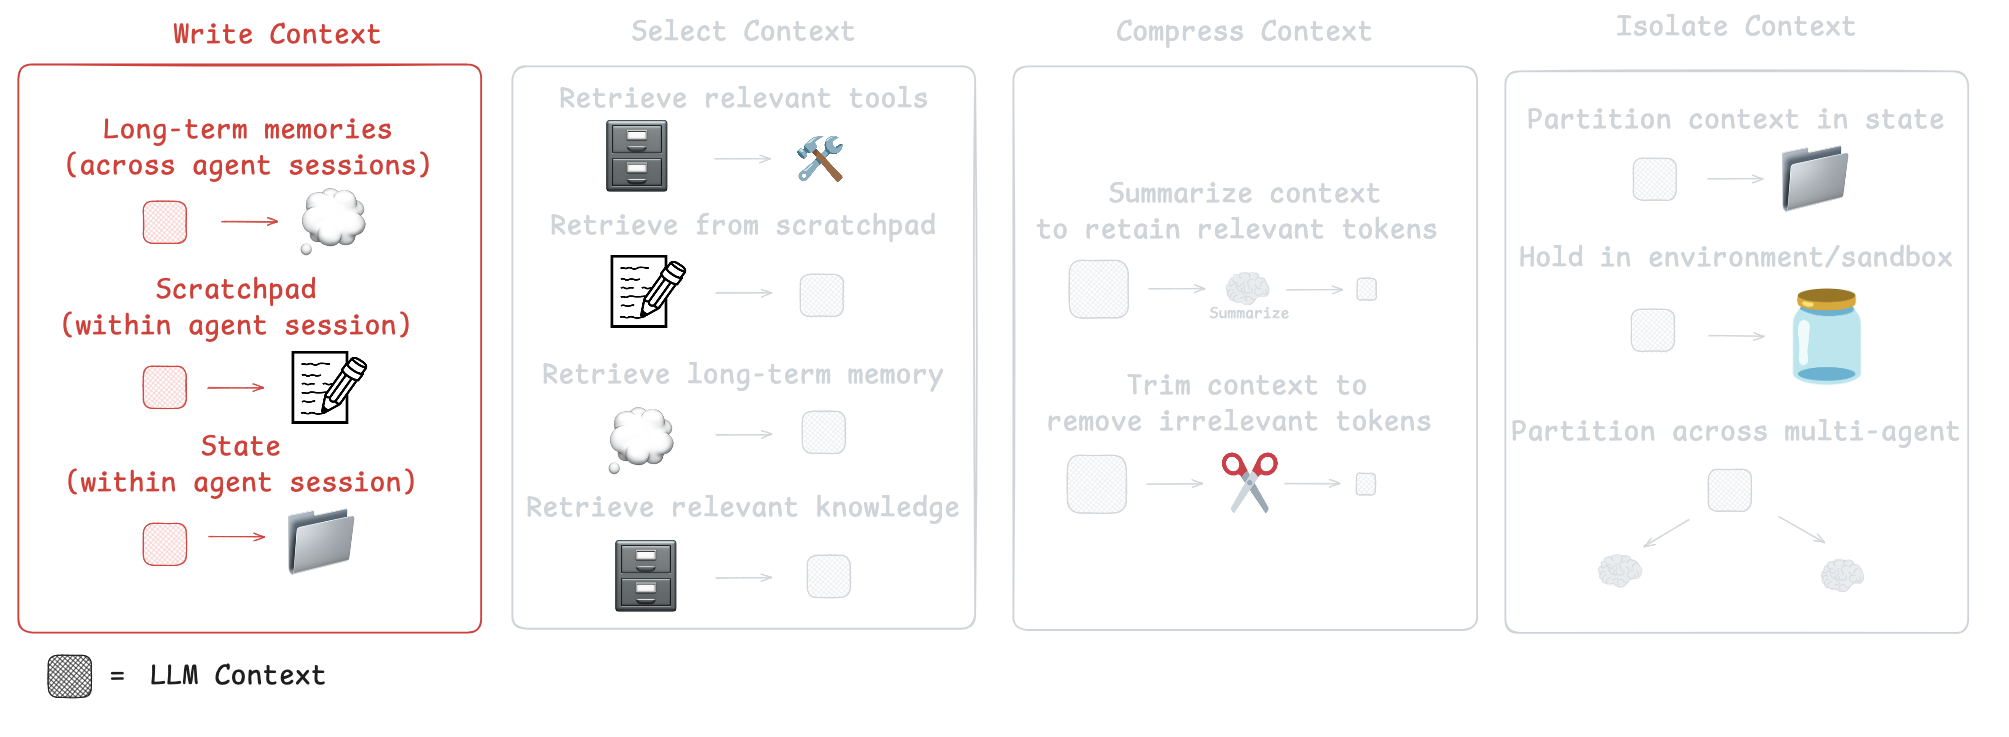

## Scratchpad

When humans solve tasks, we take notes and remember things for future, related tasks. Agents are also gaining these capabilities! Note-taking via a "[scratchpad](https://www.anthropic.com/engineering/claude-think-tool)" is one approach to persist information while an agent is performing a task. The central idea is to save information outside of the context window so that it's available to the agent on-demand. [Anthropic's multi-agent researcher](https://www.anthropic.com/engineering/built-multi-agent-research-system) illustrates a clear example of this:

> The LeadResearcher begins by thinking through the approach and saving its plan to Memory to persist the context, since if the context window exceeds 200,000 tokens it will be truncated and it is important to retain the plan.

It's worth noting that this scratchpad can be implemented in a few different ways. It could be a [tool call](https://www.anthropic.com/engineering/claude-think-tool) that [writes to a file](https://github.com/modelcontextprotocol/servers/tree/main/src/filesystem). It could also just be a field in a runtime [state object](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) that persists during the session. In either case, the intuition is clear: scratchpads let agents save useful information during a session to help them accomplish tasks.

### Scratchpad writing in LangGraph

LangGraph was designed with first-class support of both thread-scoped ([short-term](https://langchain-ai.github.io/langgraph/concepts/memory/#short-term-memory)) and [long-term memory](https://langchain-ai.github.io/langgraph/concepts/memory/#long-term-memory). Short-term memory uses [checkpointing](https://langchain-ai.github.io/langgraph/concepts/persistence/) to persist [agent state](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) across all steps of an agent session. This is extremely useful as s "scratchpad", allowing you to write information to state during agent execution and fetch it later as needed.

The state object in LangGraph serves as the central data structure that gets passed between nodes in your graph. It's a Python dictionary that can contain any JSON-serializable values including strings, numbers, lists, and dictionaries. The state acts as a shared workspace where each node can read from and write to specific fields. LangGraph uses TypedDict to provide type hints and structure to the state, making it clear what data is expected and maintained throughout the graph execution.

Here we can create a state object.

In [2]:
from typing import TypedDict

# Graph state
class State(TypedDict):
    topic: str
    joke: str

Once we've defined a state object, how do write context to it using LangGraph?

A StateGraph is LangGraph's core abstraction for building stateful, multi-step workflows. Think of it as a directed graph where each node represents a function that can read from and modify the shared state, and edges define the flow of execution between nodes. Nodes are the individual processing steps in your workflow - they receive the current state as input and return updates to be merged back into the state. Edges connect these nodes together, creating a path for execution that can be linear, conditional, or even cyclical depending on your needs.

Let's create a [chat model](https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html) selecting from [Anthropic](https://docs.anthropic.com/en/docs/about-claude/models/overview) and use it with a graph.

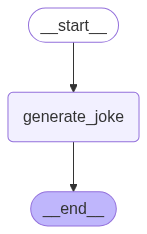

In [3]:
import os
import getpass
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("ANTHROPIC_API_KEY")

from langchain.chat_models import init_chat_model
llm = init_chat_model("anthropic:claude-sonnet-4-20250514", temperature=0)

# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""
    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    # Write the joke to state
    return {"joke": msg.content}

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [4]:
# Invoke
joke_generator_state = chain.invoke({"topic": "cats"})

# See joke is in state
joke_generator_state

{'topic': 'cats',
 'joke': "Why don't cats ever win races?\n\nBecause they always paws right before the finish line!"}

#### Learn More
 
* `Checkpointing`: Checkpointing in LangGraph creates snapshots of your graph's state after each node execution, enabling powerful capabilities for long-running tasks. These checkpoints act as save points that allow you to pause execution, resume from any point, and even rewind to previous states. This is particularly valuable for complex workflows that might take hours or days to complete, as it provides fault tolerance and the ability to recover from failures without losing progress.

* `Human-in-the-loop`: LangGraph's state persistence enables sophisticated human-in-the-loop workflows by allowing execution to be paused at any point and resumed later. This means you can interrupt a running graph, wait for human input or approval, and then continue processing from exactly where you left off. The checkpointed state ensures that all context and progress is preserved across these interruptions, making it possible to build workflows that seamlessly blend automated processing with human oversight and decision-making.

## Memory 

Scratchpads helps agents solve a task within a given session, but sometimes agents benefit from remembering things across *many* sessions! [Reflexion](https://arxiv.org/abs/2303.11366) introduced the idea of reflection following each agent turn and re-using these self-generated hints. [Generative Agents](https://ar5iv.labs.arxiv.org/html/2304.03442) created memories synthesized periodically from collections of past agent feedback.

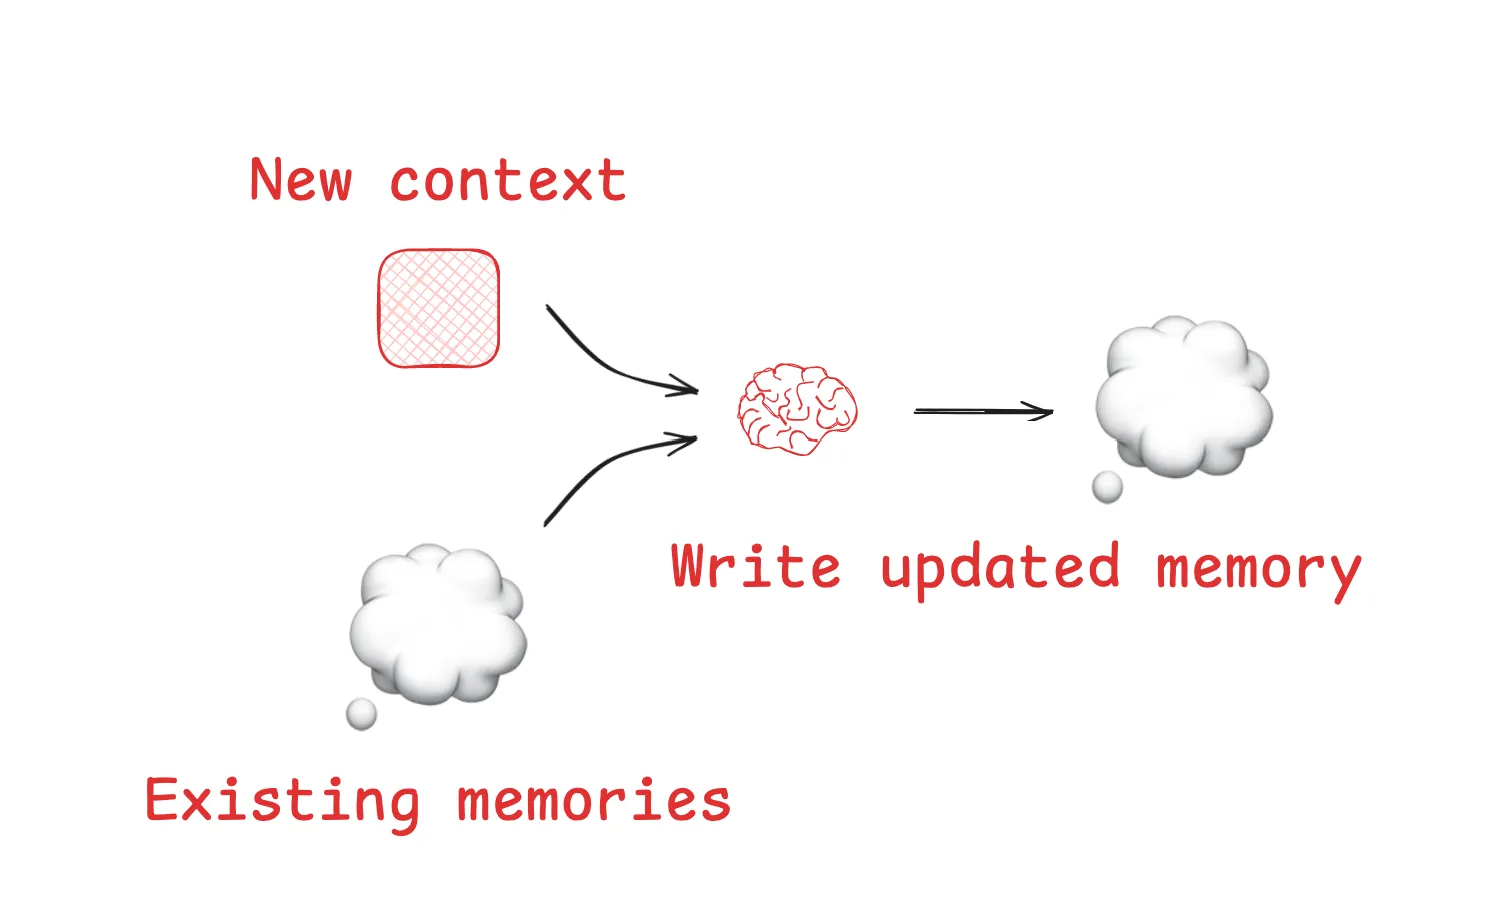

These concepts made their way into popular products like [ChatGPT](https://help.openai.com/en/articles/8590148-memory-faq), [Cursor](https://forum.cursor.com/t/0-51-memories-feature/98509), and [Windsurf](https://docs.windsurf.com/windsurf/cascade/memories), which all have mechanisms to auto-generate long-term memories based on user-agent interactions.

### Memory writing in LangGraph

LangGraph’s long-term memory allows you to persist specific context *across many sessions* with your agent. It is flexible, allowing you to save [individual files](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) (e.g., a user profile) or [collections](https://langchain-ai.github.io/langgraph/concepts/memory/#collection) of memories. In LangGraph, the `InMemoryStore` is just a Python dictionary in memory. LangGraph deployments [support long-term memory](https://github.com/langchain-ai/agents-from-scratch/blob/main/notebooks/memory.ipynb) with persistence on the local filesystem (for local deployments) or PostgreSQL for hosted deployments.

In [5]:
from langgraph.store.memory import InMemoryStore
store = InMemoryStore()

# Define namespace (user_id, application_context)
namespace = ("rlm", "joke_generator")

# Write joke
store.put(
    namespace, # namespace
    "last_joke", # key
    {"joke": joke_generator_state["joke"]} # value
)

In [8]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore

# Initialize storage and checkpointer
checkpointer = InMemorySaver()
memory_store = InMemoryStore()

# Nodes
def generate_joke(state: State, store: BaseStore):
    """First LLM call to generate initial joke"""

    # Generate joke
    msg = llm.invoke(f"Write a short joke about {state['topic']}")

    # Write joke in memory
    store.put(namespace, "last_joke", {"joke": msg.content})

    # Write the joke to state
    return {"joke": msg.content}

# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_edge("generate_joke", END)

# Re-compile with checkpointing and memory  
chain = workflow.compile(checkpointer=checkpointer, store=memory_store)

In [9]:
# Invoke
config = {"configurable": {"thread_id": "1"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

In [29]:
config = {"configurable": {"thread_id": "2"}}
joke_generator_state = chain.invoke({"topic": "cats"}, config)

Prior joke: Why don't cats ever win at poker?

Because they can't help but purr when they have a good hand!


In [10]:
joke_generator_state['joke']

"Why don't cats ever win races?\n\nBecause they always paws right before the finish line!"

In [11]:
# Confirm that we wrote the memory
memory_store.get(namespace, "last_joke").value

{'joke': "Why don't cats ever win races?\n\nBecause they always paws right before the finish line!"}

#### Learn More

* [LangMem](https://langchain-ai.github.io/langmem/) provides a set of useful abstractions to aid with writing memories.
* [Ambient Agents Course](https://github.com/langchain-ai/agents-from-scratch/blob/main/notebooks/memory.ipynb) provides a great overview of memory with a LangGraph agent.